In [1]:
import warnings
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer

from statsmodels.stats.diagnostic import het_breuschpagan

from category_encoders import LeaveOneOutEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

import statsmodels.api as sm

import seaborn as sns
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

from dateutil.relativedelta import relativedelta
from datetime import date

from IPython.display import display_html

In [2]:
from mlxtend.plotting import plot_decision_regions

import math

from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier

from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score

In [3]:
#import pydotplus
#import graphviz
#import pickle

In [4]:
#!pip install nb_black
#%load_ext nb_black

In [5]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")


def eval_preds(y_true, y_pred):
    error = y_true - y_pred

    rmse = np.sqrt((error ** 2).mean())
    mae = error.abs().mean()
    mape = (error / y_true).abs().mean()

    print(f"rmse {rmse:.2f}")
    print(f"mae {mae:.2f}")
    print(f"mape {mape:.2f}")

    line_pts = [y_true.min(), y_true.max()]
    plt.scatter(y_true, y_pred)
    plt.plot(line_pts, line_pts, c="red", ls="--", alpha=0.5)
    plt.xlabel("Actual")
    plt.ylabel("Fit")
    plt.show()

In [6]:
def display_side_by_side(*args):
    html_str = ""
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace("table", 'table style="display:inline"'), raw=True)


def top_corrs(df, column, n=20):
    corr_df = df.corr()[[column]]
    corr_df.columns = ["corr"]
    corr_df["abs_corr"] = corr_df.abs()

    top_n_num = corr_df.sort_values("abs_corr", ascending=False).head(20)
    return top_n_num


def plot_top_corrs(df, column, n=10):
    top_corrs_df = top_corrs(df, column, n)
    top_feats = top_corrs_df.index
    top_corr = df[top_feats]
    top_corr_tall = pd.melt(top_corr, column)

    fg = sns.FacetGrid(top_corr_tall, col="variable", col_wrap=5, sharex=False)
    fg.map(sns.scatterplot, "value", column)
    plt.show()
    
# from TowardsDataScience.com by Shaked Zychlinski
# URL: https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

## Pulling in weather data
from Openweather.org. URL: https://home.openweathermap.org/history_bulks/new

In [7]:
weather = pd.read_csv('http://history.openweathermap.org/storage/2190c766ac5f9f46f1c8c871c49523ec.csv')
weather.head()

,dt,dt_iso,timezone,city_name,lat,lon,temp,feels_like,temp_min,temp_max,...,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1461888000,2016-04-29 00:00:00 +0000 UTC,-10800,Vitoria,-20.297618,-40.295777,73.80,73.27,73.40,75.96,...,220,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
1,1461891600,2016-04-29 01:00:00 +0000 UTC,-10800,Vitoria,-20.297618,-40.295777,73.85,72.05,73.40,76.05,...,220,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
2,1461895200,2016-04-29 02:00:00 +0000 UTC,-10800,Vitoria,-20.297618,-40.295777,73.81,73.09,73.40,75.78,...,240,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
3,1461898800,2016-04-29 03:00:00 +0000 UTC,-10800,Vitoria,-20.297618,-40.295777,73.65,72.23,72.76,75.67,...,230,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
4,1461902400,2016-04-29 04:00:00 +0000 UTC,-10800,Vitoria,-20.297618,-40.295777,73.56,71.44,72.60,75.44,...,230,NaN,NaN,NaN,NaN,90,804,Clouds,overcast clouds,04n


In [8]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dt                   986 non-null    int64  
 1   dt_iso               986 non-null    object 
 2   timezone             986 non-null    int64  
 3   city_name            986 non-null    object 
 4   lat                  986 non-null    float64
 5   lon                  986 non-null    float64
 6   temp                 986 non-null    float64
 7   feels_like           986 non-null    float64
 8   temp_min             986 non-null    float64
 9   temp_max             986 non-null    float64
 10  pressure             986 non-null    int64  
 11  sea_level            0 non-null      float64
 12  grnd_level           0 non-null      float64
 13  humidity             986 non-null    int64  
 14  wind_speed           986 non-null    float64
 15  wind_deg             986 non-null    int

In [9]:
weather["dt_iso"] = weather["dt_iso"].map(lambda x: str(x)[:-4])

In [10]:
# changing to datetime format
weather['dt_iso'] = pd.to_datetime(weather['dt_iso'])

In [11]:
# keeping important weather data for merge
weather_drop_cols = ['dt', 'timezone', 'city_name', 'lat', 'lon', 'temp',
       'temp_min', 'temp_max', 'pressure', 'sea_level',
       'grnd_level', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h',
       'rain_3h', 'snow_1h', 'snow_3h', 'clouds_all', 'weather_id',
       'weather_description', 'weather_icon']
weather = weather.drop(columns=weather_drop_cols)

In [12]:
weather = weather.rename(columns={'dt_iso':'AppointmentDay'})

In [13]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   AppointmentDay  986 non-null    datetime64[ns, UTC]
 1   feels_like      986 non-null    float64            
 2   weather_main    986 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 23.2+ KB


In [14]:
weather.head()

,AppointmentDay,feels_like,weather_main
0,2016-04-29 00:00:00+00:00,73.27,Clouds
1,2016-04-29 01:00:00+00:00,72.05,Clouds
2,2016-04-29 02:00:00+00:00,73.09,Clouds
3,2016-04-29 03:00:00+00:00,72.23,Clouds
4,2016-04-29 04:00:00+00:00,71.44,Clouds


In [15]:
weather.feels_like = weather.feels_like.astype(int).round(0)

In [16]:
weather.weather_main.value_counts()

Clouds          574
Clear           390
Rain             11
Mist              5
Smoke             4
Thunderstorm      1
Fog               1
Name: weather_main, dtype: int64

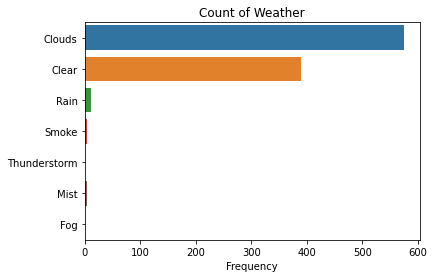

In [17]:
sns.countplot(y='weather_main', data=weather)
plt.title('Count of Weather')
plt.xlabel('Frequency')
plt.ylabel('')
plt.show()

## Pulling in main appointment data

In [18]:
df = pd.read_csv('noshowappointments.csv')

This dataset has information about 110527 medical appointments in Vitoria Brazil from 29 April - 8 June 2016
The goal is to predict whether a patient will show up to their appointment. 

Data Dictionary: 

PatientId -Identification of a patient

AppointmentID - Identification of each appointment

Gender - Male or Female

AppointmentDay - The day of the actual appointment, when they have to visit the doctor

ScheduledDay - The day someone called or registered the appointment, this is before appointment of course.

Age - Age of the patient.

Neighborhood - Where the appointment takes place.

Scholarship - True of False. Whether or not the school age patient is participating in Bolsa Famila which pays a stipend based on meeting certain metrics like class attendance or getting vaccinated. 
https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia

Hypertension - True or False

Diabetes -True or False

Alcoholism - True or False

Disability - 0-4. 0 is no disability and remaining numbers indicate how many disabilities the patient has

Reminder - True or False. 1 or more messages sent to the patient

No-show - True or False

# Things to do:
  *  Break down both dates into hour and day of week to see if there is anything significant with target.
      
      No hour data in appointment day but we do have interval in days between day scheduled and day of appointment.
  
  
  *  Check for outliers and missing data.
      
      None but we do have imbalanced classes.
  
  
  *  Investigate whether any variables can be mixed such as Hypertenion and Diabetes.
  
  
  *  Attempt to bring in weather for the appointment day since that is likely to have an impact on target.
  
      Done.
      
  
  *  Determine which vars are correlated with target and drop those not important.
  
  
  *  Find important variables that help predict whether a patient shows to their appointment. 
  
  
  *  Compare different models. KNN is best using continous data so it's ruled out here. 

In [19]:
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')

In [20]:
df.shape

(110527, 14)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [22]:
df['AppointmentID'].nunique()

110527

In [23]:
#dropping and appointmentID

df = df.drop(columns = 'AppointmentID')

In [24]:
# cleaning column names

df['Neighborhood'] = df['Neighbourhood']
df = df.drop(columns=['Neighbourhood'])

df['Hypertension'] = df['Hipertension']
df = df.drop(columns=['Hipertension'])

df['Disability'] = df['Handcap']
df = df.drop(columns=['Handcap'])

df['Reminder'] = df['SMS_received']
df = df.drop(columns=['SMS_received'])

df['no_show'] = df['No-show']
df = df.drop(columns=['No-show'])

Converting to datetime data type and creating day of week variables.

In [25]:
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])

In [26]:
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

In [27]:
# creating date variables from ScheduleDay

df["sch_weekday_num"] = df["ScheduledDay"].dt.weekday
df["sch_weekday_name"] = df["ScheduledDay"].dt.day_name()

In [28]:
# creating date variables from AppointmentDay

df["appt_weekday_num"] = df["AppointmentDay"].dt.weekday
df["appt_weekday_name"] = df["AppointmentDay"].dt.day_name()

In [29]:
df['has_diabetes_and_hyper'] = df['Hypertension'] * df['Diabetes']

In [30]:
df.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Diabetes,Alcoholism,Neighborhood,Hypertension,Disability,Reminder,no_show,sch_weekday_num,sch_weekday_name,appt_weekday_num,appt_weekday_name,has_diabetes_and_hyper
0,2.990000e+13,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,0,0,0,JARDIM DA PENHA,1,0,0,No,4,Friday,4,Friday,0
1,5.590000e+14,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,0,0,0,JARDIM DA PENHA,0,0,0,No,4,Friday,4,Friday,0
2,4.260000e+12,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,0,0,0,MATA DA PRAIA,0,0,0,No,4,Friday,4,Friday,0
3,8.680000e+11,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,0,0,0,PONTAL DE CAMBURI,0,0,0,No,4,Friday,4,Friday,0
4,8.840000e+12,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,0,1,0,JARDIM DA PENHA,1,0,0,No,4,Friday,4,Friday,1


## Merging df and weather dataframes

In [31]:
df_merge = pd.merge(df, weather, on='AppointmentDay', how='left', indicator=True)

In [32]:
df_merge.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Diabetes,Alcoholism,Neighborhood,Hypertension,...,Reminder,no_show,sch_weekday_num,sch_weekday_name,appt_weekday_num,appt_weekday_name,has_diabetes_and_hyper,feels_like,weather_main,_merge
0,2.990000e+13,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,0,0,0,JARDIM DA PENHA,1,...,0,No,4,Friday,4,Friday,0,73,Clouds,both
1,5.590000e+14,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,0,0,0,JARDIM DA PENHA,0,...,0,No,4,Friday,4,Friday,0,73,Clouds,both
2,4.260000e+12,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,0,0,0,MATA DA PRAIA,0,...,0,No,4,Friday,4,Friday,0,73,Clouds,both
3,8.680000e+11,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,0,0,0,PONTAL DE CAMBURI,0,...,0,No,4,Friday,4,Friday,0,73,Clouds,both
4,8.840000e+12,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,0,1,0,JARDIM DA PENHA,1,...,0,No,4,Friday,4,Friday,1,73,Clouds,both


In [33]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110527 entries, 0 to 110526
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   PatientId               110527 non-null  float64            
 1   Gender                  110527 non-null  object             
 2   ScheduledDay            110527 non-null  datetime64[ns, UTC]
 3   AppointmentDay          110527 non-null  datetime64[ns, UTC]
 4   Age                     110527 non-null  int64              
 5   Scholarship             110527 non-null  int64              
 6   Diabetes                110527 non-null  int64              
 7   Alcoholism              110527 non-null  int64              
 8   Neighborhood            110527 non-null  object             
 9   Hypertension            110527 non-null  int64              
 10  Disability              110527 non-null  int64              
 11  Reminder                11

In [34]:
df_merge._merge.value_counts()

both          110527
right_only         0
left_only          0
Name: _merge, dtype: int64

In [35]:
df_merge.weather_main.value_counts()

Clear     56696
Clouds    53831
Name: weather_main, dtype: int64

In [36]:
# creating interval in days between scheduled and appointment days

df_merge['day_diff'] = df_merge['AppointmentDay'] - df_merge['ScheduledDay']
df_merge['day_diff'] = df_merge['day_diff'] / np.timedelta64(1,'D')

In [37]:
df_merge.day_diff.sort_values()

104869     -0.864514
45961      -0.860486
88149      -0.856042
45969      -0.850903
86606      -0.848171
             ...    
102786    178.553079
102799    178.553275
102796    178.553461
102797    178.553681
102795    178.554873
Name: day_diff, Length: 110527, dtype: float64

In [38]:
df_merge['day_diff'] = df_merge['day_diff'].round(0)

In [39]:
df_merge.day_diff.value_counts()

-0.0      28813
-1.0      12158
 2.0       5574
 1.0       5290
 4.0       4609
          ...  
 123.0        1
 115.0        1
 100.0        1
 145.0        1
 127.0        1
Name: day_diff, Length: 135, dtype: int64

In [40]:
df_merge.day_diff.describe()

count    110527.000000
mean          9.803605
std          15.238450
min          -1.000000
25%          -0.000000
50%           3.000000
75%          14.000000
max         179.000000
Name: day_diff, dtype: float64

In [41]:
df_merge.day_diff.nunique()

135

In [42]:
df_merge.day_diff.dtype

dtype('float64')

In [43]:
# inserting weather on May 20th because there is no hour in Appointment Day to merge on. It rained all day on 20 May
# and is the only day it rained during the period in the dataset, 29 April to 8 June 2016. 
df_merge.loc[df_merge['AppointmentDay'] == '2016-05-20 00:00:00+00:00', 'weather_main'] = 'Rain'

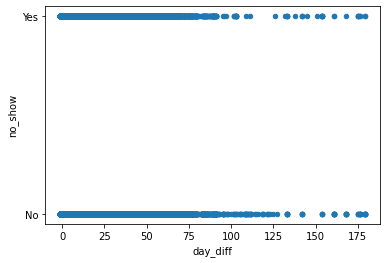

In [44]:
df_merge.plot.scatter(x='day_diff', y='no_show')
plt.show()

In [45]:
# We have a scheduled hour but no appointment hour resulting in negative day intervals based on the hour.
# Will replace with zero since negative intervals are the same day. 
df_merge.day_diff = np.where(df_merge.day_diff < 0, 0, df_merge.day_diff)

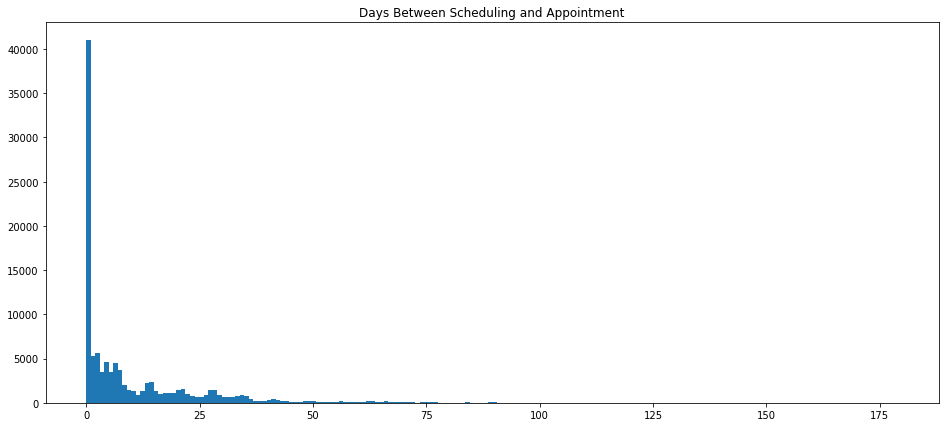

In [46]:
plt.figure(figsize=(16,7))
plt.hist(x='day_diff', data=df_merge, bins = 180)
plt.title('Days Between Scheduling and Appointment')
plt.show()

## Plotting variables with target, no_show

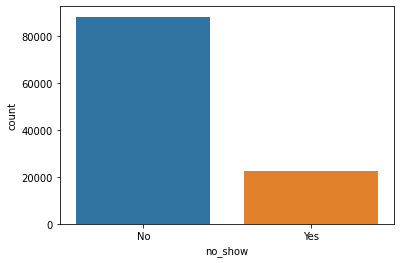

In [47]:
sns.countplot(x=df_merge['no_show'])
plt.show()

In [48]:
df_merge.no_show.value_counts(normalize=True)

No     0.798067
Yes    0.201933
Name: no_show, dtype: float64

In [49]:
df['no_show'].value_counts()

No     88208
Yes    22319
Name: no_show, dtype: int64

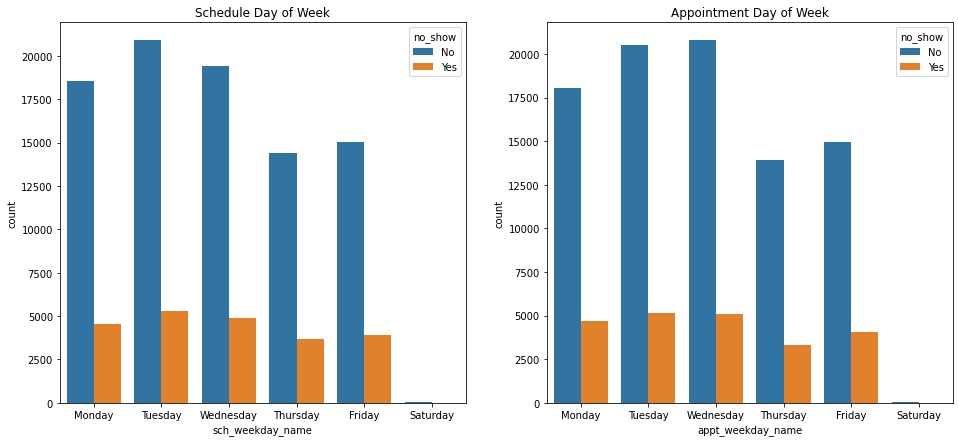

In [50]:
plt.figure(figsize=(16,7))

plt.subplot(1,2,1)
sns.countplot(x='sch_weekday_name',hue='no_show',data=df_merge, order=['Monday','Tuesday', 'Wednesday','Thursday','Friday','Saturday'])
plt.title('Schedule Day of Week')

plt.subplot(1,2,2)
sns.countplot(x='appt_weekday_name',hue='no_show',data=df_merge, order=['Monday','Tuesday', 'Wednesday','Thursday','Friday','Saturday'])
plt.title('Appointment Day of Week')
plt.show()

In [51]:
crosstable = pd.crosstab(df_merge["appt_weekday_name"], df_merge["no_show"])
crosstable

no_show,No,Yes
appt_weekday_name,,
Friday,14982,4037
Monday,18025,4690
Saturday,30,9
Thursday,13909,3338
Tuesday,20488,5152
Wednesday,20774,5093


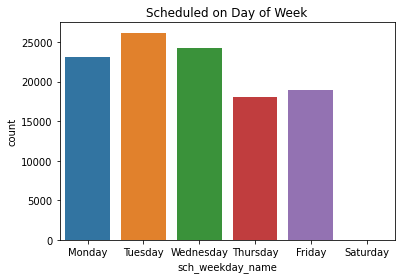

In [52]:
# Tuesday is the busiest day for scheduling appointments followed by Wednesday

sns.countplot(x=df['sch_weekday_name'], order=['Monday','Tuesday', 'Wednesday','Thursday','Friday','Saturday'])
plt.title('Scheduled on Day of Week')
plt.show()

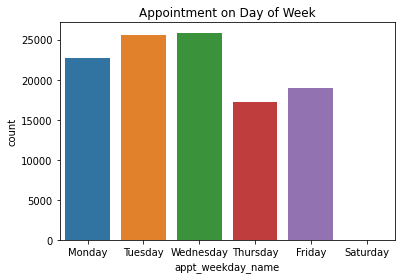

In [53]:
# Wednesday has the most appointments followed by Tuesday

sns.countplot(x=df['appt_weekday_name'], order=['Monday','Tuesday', 'Wednesday','Thursday','Friday','Saturday'])
plt.title('Appointment on Day of Week')
plt.show()

From pairplot, we can see that variables do not have a linear relationship with the target.

In [54]:
#sns.pairplot(df)
#plt.show()

In [55]:
df_merge.groupby('no_show').mean()

,PatientId,Age,Scholarship,Diabetes,Alcoholism,Hypertension,Disability,Reminder,sch_weekday_num,appt_weekday_num,has_diabetes_and_hyper,feels_like,day_diff
no_show,,,,,,,,,,,,,
No,1.476841e+14,37.790064,0.093903,0.073837,0.030417,0.204392,0.022742,0.291334,1.847780,1.857439,0.060595,77.166130,8.515724
Yes,1.467530e+14,34.317667,0.115507,0.064071,0.030333,0.169004,0.020297,0.438371,1.868184,1.861419,0.051122,77.106994,15.438236


In [56]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110527 entries, 0 to 110526
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   PatientId               110527 non-null  float64            
 1   Gender                  110527 non-null  object             
 2   ScheduledDay            110527 non-null  datetime64[ns, UTC]
 3   AppointmentDay          110527 non-null  datetime64[ns, UTC]
 4   Age                     110527 non-null  int64              
 5   Scholarship             110527 non-null  int64              
 6   Diabetes                110527 non-null  int64              
 7   Alcoholism              110527 non-null  int64              
 8   Neighborhood            110527 non-null  object             
 9   Hypertension            110527 non-null  int64              
 10  Disability              110527 non-null  int64              
 11  Reminder                11

In [57]:
# creating binary for disability

df_merge['disability'] = df_merge.Disability.transform(lambda x: int(x > 0))

In [58]:
df_merge.disability.value_counts()

0    108286
1      2241
Name: disability, dtype: int64

In [59]:
df_merge['is_male'] = df_merge.Gender.transform(lambda x: int(x =='M'))

In [60]:
df_merge.is_male.value_counts()

0    71840
1    38687
Name: is_male, dtype: int64

In [61]:
df_merge['no_show'] = df_merge.no_show.transform(lambda x: int(x =='Yes'))

In [62]:
df_merge.no_show.value_counts()

0    88208
1    22319
Name: no_show, dtype: int64

In [63]:
df_merge = df_merge.drop(columns = ['Gender', 'Disability'])

In [64]:
df_merge.head()

,PatientId,ScheduledDay,AppointmentDay,Age,Scholarship,Diabetes,Alcoholism,Neighborhood,Hypertension,Reminder,...,sch_weekday_name,appt_weekday_num,appt_weekday_name,has_diabetes_and_hyper,feels_like,weather_main,_merge,day_diff,disability,is_male
0,2.990000e+13,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,0,0,0,JARDIM DA PENHA,1,0,...,Friday,4,Friday,0,73,Clouds,both,0.0,0,0
1,5.590000e+14,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,0,0,0,JARDIM DA PENHA,0,0,...,Friday,4,Friday,0,73,Clouds,both,0.0,0,1
2,4.260000e+12,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,0,0,0,MATA DA PRAIA,0,0,...,Friday,4,Friday,0,73,Clouds,both,0.0,0,0
3,8.680000e+11,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,0,0,0,PONTAL DE CAMBURI,0,0,...,Friday,4,Friday,0,73,Clouds,both,0.0,0,0
4,8.840000e+12,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,0,1,0,JARDIM DA PENHA,1,0,...,Friday,4,Friday,1,73,Clouds,both,0.0,0,0


In [65]:
categorical = df_merge.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

Neighborhood
81
sch_weekday_name
6
appt_weekday_name
6
weather_main
3


In [66]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110527 entries, 0 to 110526
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   PatientId               110527 non-null  float64            
 1   ScheduledDay            110527 non-null  datetime64[ns, UTC]
 2   AppointmentDay          110527 non-null  datetime64[ns, UTC]
 3   Age                     110527 non-null  int64              
 4   Scholarship             110527 non-null  int64              
 5   Diabetes                110527 non-null  int64              
 6   Alcoholism              110527 non-null  int64              
 7   Neighborhood            110527 non-null  object             
 8   Hypertension            110527 non-null  int64              
 9   Reminder                110527 non-null  int64              
 10  no_show                 110527 non-null  int64              
 11  sch_weekday_num         11

In [67]:
#plt.figure(figsize=(15,5))
#plt.barh(df_merge.groupby("disability")["disability"].count().index, 
#        df_merge.groupby("disability")["disability"].count(), 
#        color=["green","orange"])
#plt.title("Count of Disability")
#plt.show()

In [68]:
df_merge.appt_weekday_num.value_counts()

2    25867
1    25640
0    22715
4    19019
3    17247
5       39
Name: appt_weekday_num, dtype: int64

In [69]:
# creating columns for preprocessing

drop_cats = ['JARDIM CAMBURI', 'Clear', 1, 2]

cat_cols = ['Neighborhood', 'weather_main', 'sch_weekday_num', 'appt_weekday_num']

bin_cols = ['is_male','Scholarship', 'Alcoholism', 'Reminder', 'has_diabetes_and_hyper',
            'disability']

num_cols = ['PatientId', 'Age', 'feels_like', 'day_diff']

Looking at categorical data with our target, only two stand out. Those who get reminders have a greater percentage of showing up. Also, those who have a scholarship have a slightly higher percentage of not showing up. The interaction between hypertension and diabetes appears unchanged from either of the variables alone. 

no_show,0,1
is_male,,
0,0.796854,0.203146
1,0.800321,0.199679


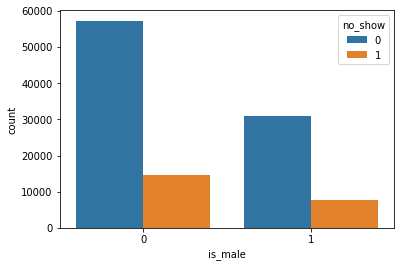

no_show,0,1
Scholarship,,
0,0.801928,0.198072
1,0.762637,0.237363


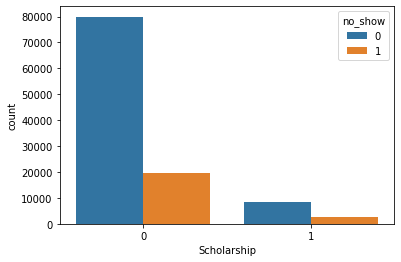

no_show,0,1
Alcoholism,,
0,0.798054,0.201946
1,0.798512,0.201488


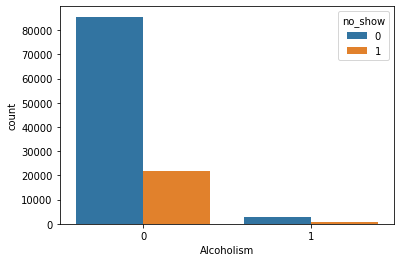

no_show,0,1
Reminder,,
0,0.832967,0.167033
1,0.724255,0.275745


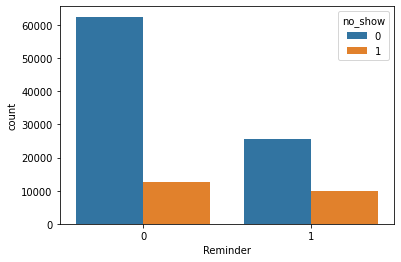

no_show,0,1
has_diabetes_and_hyper,,
0,0.796446,0.203554
1,0.824083,0.175917


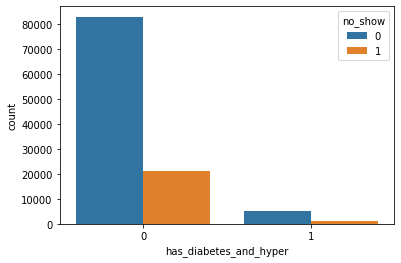

no_show,0,1
disability,,
0,0.797647,0.202353
1,0.818385,0.181615


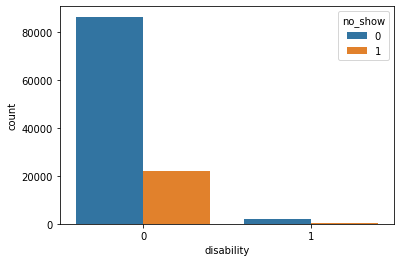

In [70]:
for bin_col in bin_cols:
    display(pd.crosstab(df_merge[bin_col], df_merge["no_show"], normalize="index"))

    sns.countplot(x=df_merge[bin_col], hue=df_merge["no_show"])
    plt.show()

Visualing numerical data with target. Younger ages appear to miss their appointment more than older patients. It also looks like more days between scheduling the appointment and the appointment day has more no_shows. 

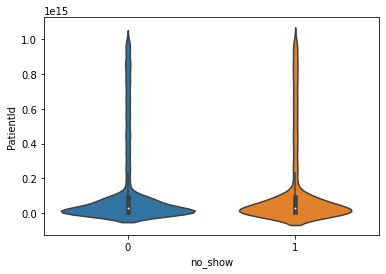

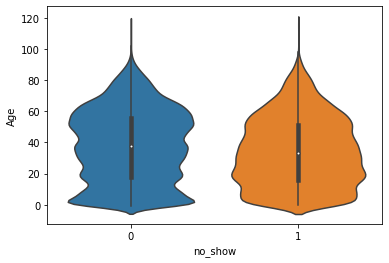

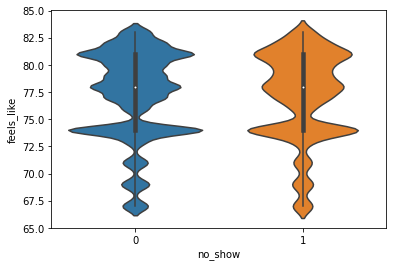

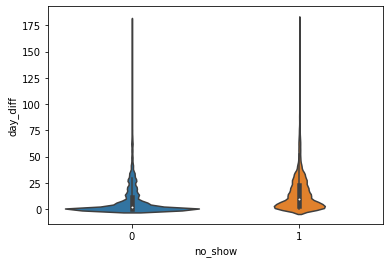

In [71]:
for num_col in num_cols:
    sns.violinplot(x=df_merge["no_show"], y=df_merge[num_col])
    plt.show()

In [72]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110527 entries, 0 to 110526
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   PatientId               110527 non-null  float64            
 1   ScheduledDay            110527 non-null  datetime64[ns, UTC]
 2   AppointmentDay          110527 non-null  datetime64[ns, UTC]
 3   Age                     110527 non-null  int64              
 4   Scholarship             110527 non-null  int64              
 5   Diabetes                110527 non-null  int64              
 6   Alcoholism              110527 non-null  int64              
 7   Neighborhood            110527 non-null  object             
 8   Hypertension            110527 non-null  int64              
 9   Reminder                110527 non-null  int64              
 10  no_show                 110527 non-null  int64              
 11  sch_weekday_num         11

In [73]:
df_merge.no_show.value_counts()

0    88208
1    22319
Name: no_show, dtype: int64

## Looking at scheduled time and appointment time

In [74]:
df_merge.AppointmentDay.dt.day.value_counts().sort_index()

1     4464
2     8686
3     8346
4     4168
5     4273
6     8571
7     4416
8     4479
9     4520
10    4308
11    4474
12    4394
13    3987
14      39
16    4613
17    4372
18    4373
19    4270
20    3828
24    4009
25    3909
29    3235
30    4514
31    4279
Name: AppointmentDay, dtype: int64

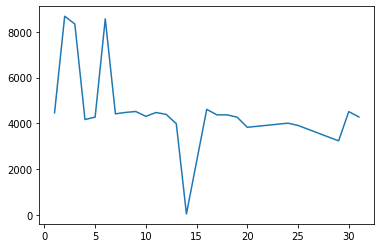

In [75]:

df_merge.AppointmentDay.dt.day.value_counts().sort_index().plot()

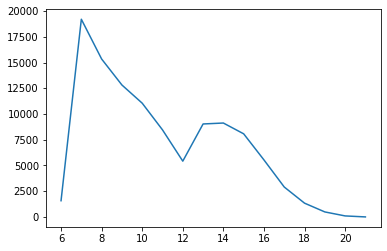

In [76]:
df_merge.ScheduledDay.dt.hour.value_counts().sort_index().plot()

## Model Prep

In [77]:
X = df_merge.drop(columns=["no_show", '_merge', 'sch_weekday_name', 'appt_weekday_name','Diabetes', 'Hypertension',
                          'ScheduledDay', 'AppointmentDay'])
y = df_merge["no_show"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [78]:
# fmt: off
preprocessing = ColumnTransformer([
    ('leaveoneoutencoder', LeaveOneOutEncoder(), cat_cols),
    ('scale', StandardScaler(), num_cols)
], remainder='passthrough')
# fmt: on

In [79]:
# fmt: off
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('xgb', XGBClassifier(use_label_encoder=False))
    #("model", RandomForestClassifier())
])
# fmt: on

In [80]:
pipeline.fit(X_train, y_train)

train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

[04:24:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train score: 0.798068332183531
Test score: 0.7980638740613408


In [81]:
# pipline.predict only requires X, not y
y_pred = pipeline.predict(X_test)

confusion_mat = confusion_matrix(y_test, y_pred)
confusion_df = pd.DataFrame(
    confusion_mat,
    index=["actual_show", "actual_No_show"],
    columns=["pred_show", "pred_No_show"],
)
# print(confusion_df)
display(confusion_df)

print(classification_report(y_test, y_pred))

,pred_show,pred_No_show
actual_show,17642,0
actual_No_show,4464,0


              precision    recall  f1-score   support

           0       0.80      1.00      0.89     17642
           1       0.00      0.00      0.00      4464

    accuracy                           0.80     22106
   macro avg       0.40      0.50      0.44     22106
weighted avg       0.64      0.80      0.71     22106



C:\Users\Mike\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Need to balance our data as below

In [113]:
# Isolating the 2 classes predictors
X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]

In [114]:
n_0 = X_train_0.shape[0]
n_1 = X_train_1.shape[0]

In [115]:
n_0

70566

In [116]:
n_1

17855

In [117]:
n = 20000

In [118]:
# Sample majority class to have less observations
X_train_0_sample = X_train_0.sample(n, replace=False, random_state=42)

# Sample minority class to have more observations
X_train_1_sample = X_train_1.sample(n, replace=True, random_state=42)

In [119]:
# Re-combine data (using the downsampled X for majority class)
X_train_resample = pd.concat((X_train_1_sample, X_train_0_sample))
X_train_resample = X_train_resample.reset_index(drop=True)

y_train_resample = np.array([1] * n + [0] * n)

In [120]:
X_train_resample.shape

(40000, 14)

In [123]:
y_train_resample.mean()

0.5

In [91]:
params = {
    "xgb__colsample_bytree": [0.001, 0.01, 0.1, 0.5],
    "xgb__max_depth": [3, 4, 5],
    "xgb__subsample": [0.001, 0.01, 0.1, 0.5],
}

n_trees = 100
learning_rate = 2 / n_trees

In [92]:
pipeline_cv = GridSearchCV(pipeline, params, verbose=1, cv=2)
pipeline_cv.fit(X_train_resample, y_train_resample)

pipeline_cv.best_params_

Fitting 2 folds for each of 48 candidates, totalling 96 fits
[04:24:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[04:24:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:24:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:24:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:24:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[04:25:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:25:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:25:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:25:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[04:25:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:25:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:25:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:25:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[04:25:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:25:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:25:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:25:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:   58.8s finished


[04:25:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'xgb__colsample_bytree': 0.001, 'xgb__max_depth': 3, 'xgb__subsample': 0.001}

In [93]:
pipeline_cv.best_estimator_['xgb'].feature_importances_

array([0.07595685, 0.3647282 , 0.0300642 , 0.02657149, 0.07398771,
       0.14188328, 0.10200884, 0.08477136, 0.        , 0.        ,
       0.04963021, 0.        , 0.        , 0.05039783], dtype=float32)

In [94]:
importance_df = pd.DataFrame(
    {"feat": X_train.columns, "importance": pipeline_cv.best_estimator_['xgb'].feature_importances_}
)
importance_df.sort_values("importance", ascending=False)

,feat,importance
1,Age,0.364728
5,Reminder,0.141883
6,sch_weekday_num,0.102009
7,appt_weekday_num,0.084771
0,PatientId,0.075957
4,Neighborhood,0.073988
13,is_male,0.050398
10,weather_main,0.049630
2,Scholarship,0.030064
3,Alcoholism,0.026571


It looks like Age and Reminder are the two most important features. Day of the week the appoint was scheduled as well as the appointment itself are also important in the model. 

In [95]:
#best_model = pipeline_cv.best_estimator_
#with open("saved_model.pkl", "wb") as f:
#    pickle.dump(best_model, f)

In [96]:
train_score = pipeline_cv.score(X_train_resample, y_train_resample)
test_score = pipeline_cv.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}\n")

y_pred = pipeline_cv.predict(X_test)

confusion_mat = confusion_matrix(y_test, y_pred)
confusion_df = pd.DataFrame(
    confusion_mat,
    index=["actual_show", "actual_No_show"],
    columns=["pred_show", "pred_No_show"],
)
display(confusion_df)

print(classification_report(y_test, y_pred))

Train score: 0.52405
Test score: 0.7778431195150638



,pred_show,pred_No_show
actual_show,16792,850
actual_No_show,4061,403


              precision    recall  f1-score   support

           0       0.81      0.95      0.87     17642
           1       0.32      0.09      0.14      4464

    accuracy                           0.78     22106
   macro avg       0.56      0.52      0.51     22106
weighted avg       0.71      0.78      0.72     22106



In [97]:
xgb_errors = df_merge.copy()
xgb_errors = xgb_errors.loc[y_test.index, :]

xgb_errors["y_true"] = y_test
xgb_errors["y_pred"] = y_pred

xgb_errors = xgb_errors[xgb_errors["y_true"] != xgb_errors["y_pred"]]

print(f'mean prob of patient no show for errors: {xgb_errors["no_show"].mean()}')


mean prob of patient no show for errors: 0.8269191610669925


Some ways to improve model:
* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* Making more iterations
* Trying a different loss function
* Changing the structure of the weak learner by allowing more leaves in the tree or using other modifications

## Trying a Random Forest Classifier

In [98]:
# fmt: off
preprocessing = ColumnTransformer([
    ('encode_cats', LeaveOneOutEncoder(), cat_cols),
    ('scale', StandardScaler(), num_cols)
], remainder='passthrough')
# fmt: on

In [99]:
# fmt: off
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ("rfc", RandomForestClassifier()),
])
# fmt: on

grid = {
    "rfc__n_estimators": [200, 350, 500],
    "rfc__max_depth": [5, 7, 9],
    "rfc__min_samples_leaf": [150, 175, 200],
}


In [100]:
pipeline_cv = GridSearchCV(pipeline, grid, verbose=1, cv=2)
pipeline_cv.fit(X_train_resample, y_train_resample)

pipeline_cv.best_params_

Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  3.1min finished


{'rfc__max_depth': 7, 'rfc__min_samples_leaf': 150, 'rfc__n_estimators': 200}

In [101]:
train_score = pipeline_cv.score(X_train_resample, y_train_resample)
test_score = pipeline_cv.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}\n")

y_pred = pipeline_cv.predict(X_test)

confusion_mat = confusion_matrix(y_test, y_pred)
confusion_df = pd.DataFrame(
    confusion_mat,
    index=["actual_show", "actual_no_show"],
    columns=["pred_show", "pred_no_show"],
)
display(confusion_df)

print(classification_report(y_test, y_pred))

Train score: 0.5082
Test score: 0.7957115715190446



,pred_show,pred_no_show
actual_show,17521,121
actual_no_show,4395,69


              precision    recall  f1-score   support

           0       0.80      0.99      0.89     17642
           1       0.36      0.02      0.03      4464

    accuracy                           0.80     22106
   macro avg       0.58      0.50      0.46     22106
weighted avg       0.71      0.80      0.71     22106



## Trying a SVC

In [102]:
# fmt: off

preprocessing = ColumnTransformer([
    ('encode_cats', LeaveOneOutEncoder(), cat_cols),
    ('scale', StandardScaler(), num_cols)
], remainder='passthrough')

# fmt: on

In [103]:
# fmt: off
pipeline = Pipeline([
    ("preprocessing", preprocessing), 
    ("svc", SVC())
])
# fmt: on

grid = {
    "svc__kernel": ["linear", "poly", "rbf"],
    "svc__degree": [2, 3],
    "svc__C": [0.001, 0.01, 0.1, 1.0],
}

pipeline_cv = GridSearchCV(pipeline, grid, cv=2, n_jobs=-1)

In [104]:
pipeline_cv.fit(X_train_resample, y_train_resample)

print("Best params:")
print(pipeline_cv.best_params_)

print(f"\ntrain score: {pipeline_cv.score(X_train_resample, y_train_resample):.3f}")
print(f"test score: {pipeline_cv.score(X_test, y_test):.3f}\n")

y_pred = pipeline_cv.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best params:
{'svc__C': 1.0, 'svc__degree': 2, 'svc__kernel': 'rbf'}

train score: 0.666
test score: 0.578

[[9142 8500]
 [ 834 3630]]
              precision    recall  f1-score   support

           0       0.92      0.52      0.66     17642
           1       0.30      0.81      0.44      4464

    accuracy                           0.58     22106
   macro avg       0.61      0.67      0.55     22106
weighted avg       0.79      0.58      0.62     22106



In [105]:
#svc_errors = df_merge.copy()
#svc_errors = svc_errors.loc[y_test.index, :]

#svc_errors["y_true"] = y_test
#svc_errors["y_pred"] = y_pred

#svc_errors = svc_errors[svc_errors["y_true"] != svc_errors["y_pred"]]

#print(f'mean prob of no show for errors: {svc_errors["no_show"].mean()}')

#sns.swarmplot(y=svc_errors["no_show"])
#plt.show()

## Trying Logistic Regression